In [29]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, PowerTransformer
from scipy import stats

def create_date_features(df):
    df = df.copy()
    df['year'] = df.index.year
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['week'] = df.index.isocalendar().week
    df['dayofyear'] = df.index.dayofyear
    return df

def clean_nas(df):
    df = df.copy()
    df.ffill(inplace=True)
    df.dropna(inplace=True)
    return df

def add_cfs_lags(df):
    target_map = df['CFS'].to_dict()
    df['CFS_lag1'] = (df.index - pd.Timedelta('1 days')).map(target_map)
    df['CFS_lag2'] = (df.index - pd.Timedelta('2 days')).map(target_map)
    df['CFS_lag3'] = (df.index - pd.Timedelta('3 days')).map(target_map)
    df['CFS_lag365'] = (df.index - pd.Timedelta('365 days')).map(target_map)
    return df

def add_temp_lags(df):
    target_map = df['TAVG_origValue'].to_dict()
    df['TAVG_lag1'] = (df.index - pd.Timedelta('1 days')).map(target_map)
    df['TAVG_lag2'] = (df.index - pd.Timedelta('2 days')).map(target_map)
    df['TAVG_lag3'] = (df.index - pd.Timedelta('3 days')).map(target_map)
    df['TAVG_lag365'] = (df.index - pd.Timedelta('365 days')).map(target_map)
    return df

def add_first_difference(df, column_name='WTEQ_origValue'):
    if column_name not in df.columns:
        raise ValueError(f"Column '{column_name}' does not exist in the DataFrame")

    diff_column_name = f'{column_name}_diff'
    df[diff_column_name] = df[column_name].diff()

    return df

# Look at daily relationship

In [31]:
scaler = MinMaxScaler()
df_daily = pd.read_csv('./data/daily.csv')
df_daily = df_daily.set_index('date')
df_daily.index = pd.to_datetime(df_daily.index)

numerical_cols = df_daily.select_dtypes(include=[np.number])
dfd_scaled = pd.DataFrame(scaler.fit_transform(numerical_cols), 
                         columns=numerical_cols.columns)

df_daily['date'] = pd.to_datetime(df_daily.index)
dfd_scaled['date'] = pd.to_datetime(df_daily.index)
df_daily['year'] = df_daily['date'].dt.year
df_daily['month'] = df_daily['date'].dt.month
df_daily['day'] = df_daily['date'].dt.dayofyear
df_daily = add_cfs_lags(df_daily)

df_daily.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 12584 entries, 1990-01-01 to 2024-06-14
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   TAVG_flag       12344 non-null  object        
 1   TAVG_origFlag   12344 non-null  object        
 2   TAVG_origValue  12344 non-null  float64       
 3   TAVG_value      12343 non-null  float64       
 4   WTEQ_average    12584 non-null  float64       
 5   WTEQ_flag       12584 non-null  object        
 6   WTEQ_origFlag   12584 non-null  object        
 7   WTEQ_origValue  12584 non-null  float64       
 8   WTEQ_value      12584 non-null  float64       
 9   agency_cd       12584 non-null  object        
 10  site_no         12584 non-null  int64         
 11  CFS             12584 non-null  int64         
 12  status          12584 non-null  object        
 13  date            12584 non-null  datetime64[ns]
 14  year            12584 non-null  int32

In [32]:
dfd_scaled.describe()

,TAVG_origValue,TAVG_value,WTEQ_average,WTEQ_origValue,WTEQ_value,site_no,CFS,date
count,12344.000000,12343.000000,12584.000000,12584.000000,12584.000000,12584.0,12584.000000,12584
mean,0.678290,0.678363,0.373659,0.315756,0.237387,0.0,0.080910,2007-03-24 12:00:00
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,1990-01-01 00:00:00
25%,0.580306,0.580306,0.022901,0.105495,0.000000,0.0,0.019401,1998-08-12 18:00:00
50%,0.675908,0.675908,0.316794,0.274725,0.191176,0.0,0.031890,2007-03-24 12:00:00
75%,0.784895,0.784895,0.664122,0.468132,0.406863,0.0,0.072147,2015-11-03 06:00:00
max,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,2024-06-14 00:00:00
std,0.140011,0.140051,0.338007,0.209718,0.233733,0.0,0.119481,NaN


## Look at covariates for hourly and daily data

<Axes: xlabel='date', ylabel='values'>

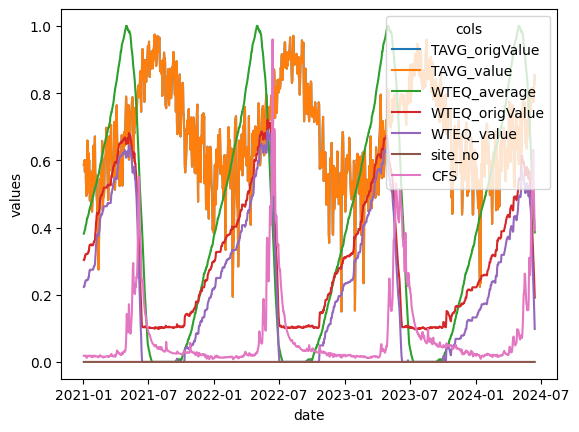

In [33]:
sns.lineplot(data=dfd_scaled[dfd_scaled["date"] > pd.to_datetime("2021-01-01")].melt('date', var_name='cols', value_name='values'), 
            x='date', 
            y='values',
            hue='cols'
            )

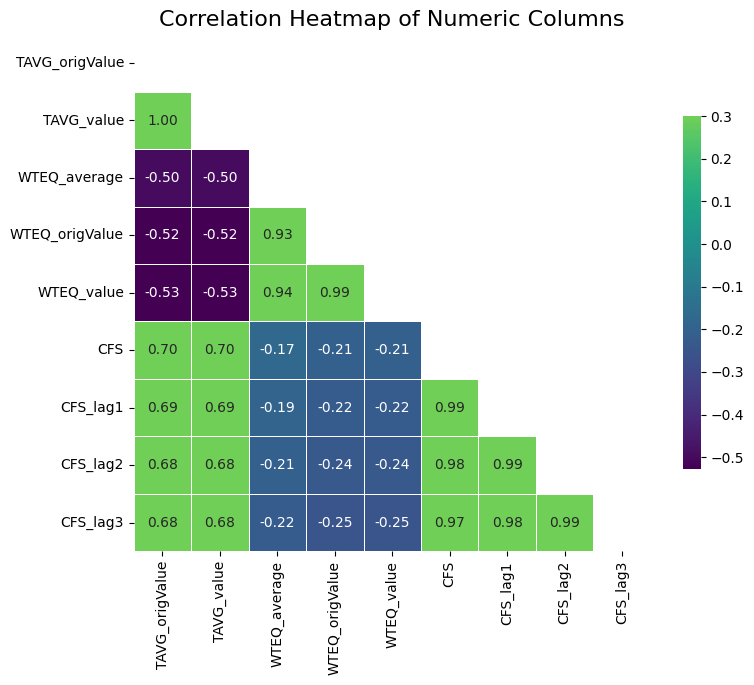

In [42]:
numeric_columns = ['TAVG_origValue', 'TAVG_value', 'WTEQ_average', 
                   'WTEQ_origValue', 'WTEQ_value', 'CFS', 'CFS_lag1', 'CFS_lag2', "CFS_lag3"]

corr_matrix = df_daily[numeric_columns].corr(method='spearman')
plt.figure(figsize=(8, 8))
cmap = sns.color_palette('viridis', as_cmap=True)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, 
            mask=mask, 
            cmap=cmap, 
            vmax=.3,
            center=0,
            square=True, 
            linewidths=.5, 
            cbar_kws={"shrink": .5}, 
            annot=True,
            fmt=".2f")

plt.title('Correlation Heatmap of Numeric Columns', fontsize=16)
plt.tight_layout()
plt.show()

/Users/finnvaughankraska/dev/gallaflow/explore/.venv/lib/python3.12/site-packages/seaborn/axisgrid.py:1513: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(x=vector, **plot_kwargs)
/Users/finnvaughankraska/dev/gallaflow/explore/.venv/lib/python3.12/site-packages/seaborn/axisgrid.py:1513: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(x=vector, **plot_kwargs)
/Users/finnvaughankraska/dev/gallaflow/explore/.venv/lib/python3.12/site-packages/seaborn/axisgrid.py:1513: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(x=vector, **plot_kwargs)
/Users/finnvaughankraska/dev/gallaflow/explore/.venv/lib/python3.12/site-packages/seaborn/axisgrid.py:1513: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(x

<Figure size 1600x1400 with 0 Axes>

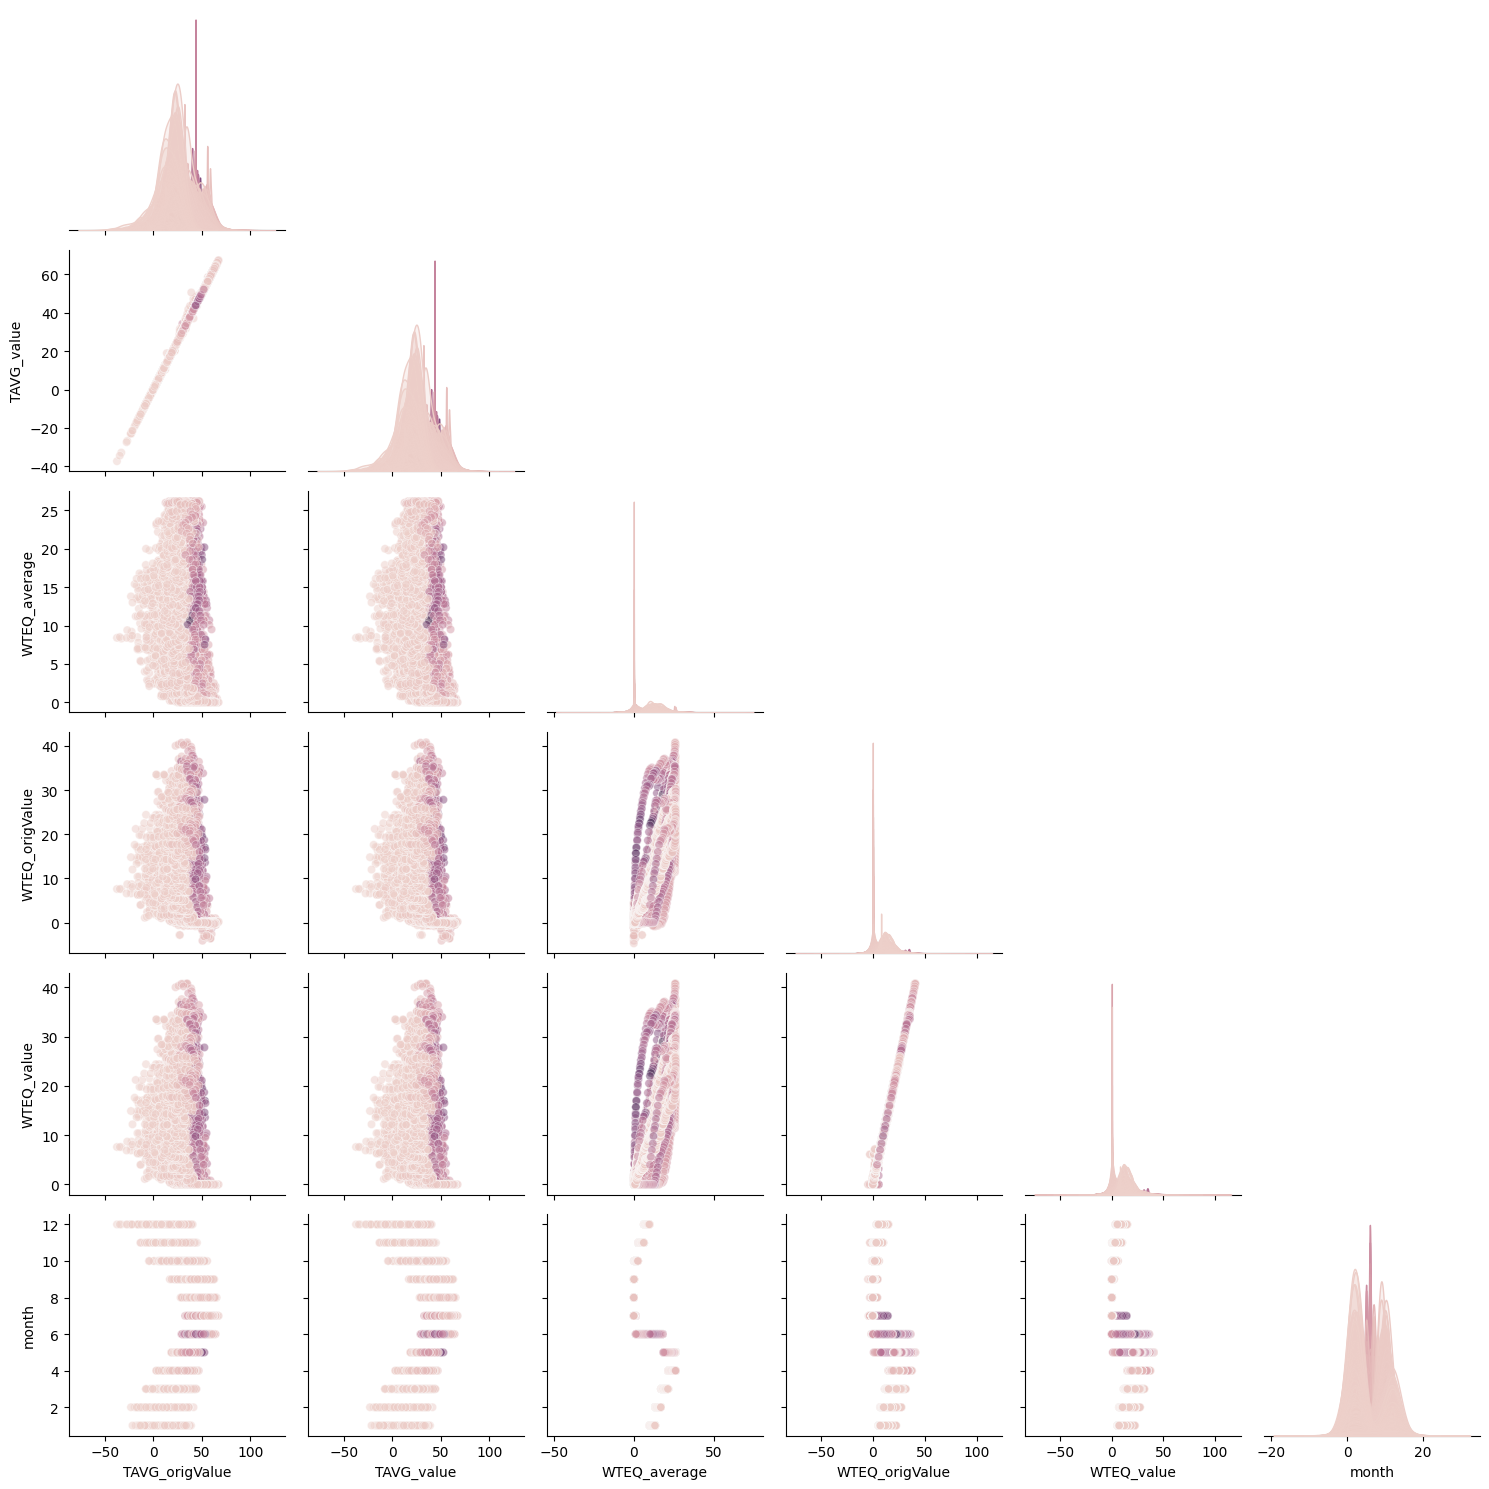

In [38]:
numeric_columns = ['TAVG_origValue', 'TAVG_value', 'WTEQ_average', 
                   'WTEQ_origValue', 'WTEQ_value', 'CFS', 'month']

plt.figure(figsize=(16, 14))
g = sns.PairGrid(df_daily[numeric_columns], 
                 diag_sharey=False,
                 hue="CFS",
                 corner=True)

g.map_diag(sns.kdeplot, fill=True)
g.map_lower(sns.scatterplot, alpha=0.5)
plt.tight_layout()